In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [11]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Data Exploration

In [32]:
train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')

C:\Users\timst\AppData\Local\Temp\ipykernel_1528\1994350583.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')


In [13]:
# #drop target variable
# df = train_data.drop(columns='Claim Injury Type')

In [36]:
train_data.head()

array(['2. NON-COMP', '4. TEMPORARY', nan, '3. MED ONLY',
       '5. PPD SCH LOSS', '6. PPD NSL', '1. CANCELLED', '8. DEATH',
       '7. PTD'], dtype=object)

In [ ]:
train_data.tail()

In [24]:
train_data.shape

(593471, 31)

In [ ]:
train_data.info()

In [45]:
train_data.describe(include='O')

,Accident Date,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,570337,574026,593471,574026,559466,187245,574026,574026,574026,574026,574026,574026,150798,574026,564068,574026,558386,558369,556944,545389,574026
unique,5539,3,1096,2,2475,1648,2046,8,8,63,2,8,1094,4,20,5,74,56,54,10060,1
top,2020-03-01,N,2020-03-06,N,2021-05-11,2021-04-21,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,N,NYC,2022-04-15,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,1245,571412,1422,392291,1847,350,111144,285368,291078,60430,546505,270779,440,335218,114339,265981,46610,153373,51862,3302,574026


Variables like _`Attorney/Representative`_ and maybe _`COVID-19 Indicator`_ can be changed to Boolean or some other form of data enconding

In [43]:
train_data['Attorney/Representative'].value_counts() / train_data.shape[0] * 100

Attorney/Representative
N    66.101124
Y    30.622389
Name: count, dtype: float64

In [44]:
train_data['COVID-19 Indicator'].value_counts() / train_data.shape[0] * 100 

COVID-19 Indicator
N    92.086218
Y     4.637295
Name: count, dtype: float64

Explore target variable

In [41]:
train_data['Claim Injury Type'].value_counts() / train_data.shape[0]*100

Claim Injury Type
2. NON-COMP        49.046710
4. TEMPORARY       25.023464
3. MED ONLY        11.610677
5. PPD SCH LOSS     8.135191
1. CANCELLED        2.102377
6. PPD NSL          0.709554
8. DEATH            0.079195
7. PTD              0.016345
Name: count, dtype: float64

### Missing values
_`OIICS Nature of Injury Description`_ has no values

_`IME-4 Count`_, _`First Hearing Date`_ and _`C-3 Date`_ have >50% of entries missing ( 77.6%, 74.5 and 68.4%, respectively)

In [46]:
train_data.isnull().sum()/train_data.shape[0]*100

Accident Date                           3.898084
Age at Injury                           3.276487
Alternative Dispute Resolution          3.276487
Assembly Date                           0.000000
Attorney/Representative                 3.276487
Average Weekly Wage                     8.104187
Birth Year                              8.176137
C-2 Date                                5.729850
C-3 Date                               68.449174
Carrier Name                            3.276487
Carrier Type                            3.276487
Claim Injury Type                       3.276487
County of Injury                        3.276487
COVID-19 Indicator                      3.276487
District Name                           3.276487
First Hearing Date                     74.590502
Gender                                  3.276487
IME-4 Count                            77.622664
Industry Code                           4.954412
Industry Code Description               4.954412
Medical Fee Region  

In [56]:
train_data['C-3 Date'].value_counts(dropna=False)
len(train_data['C-3 Date'].unique())

1649

In [61]:
train_data['First Hearing Date'].value_counts(dropna=False)

print(len(train_data['First Hearing Date'].unique()))

1095


In [62]:
train_data['IME-4 Count'].value_counts(dropna=False)

print(len(train_data['IME-4 Count'].unique()))

42


In [47]:
#duplicated values
train_data.duplicated().sum()

18350

### Feature Correlation

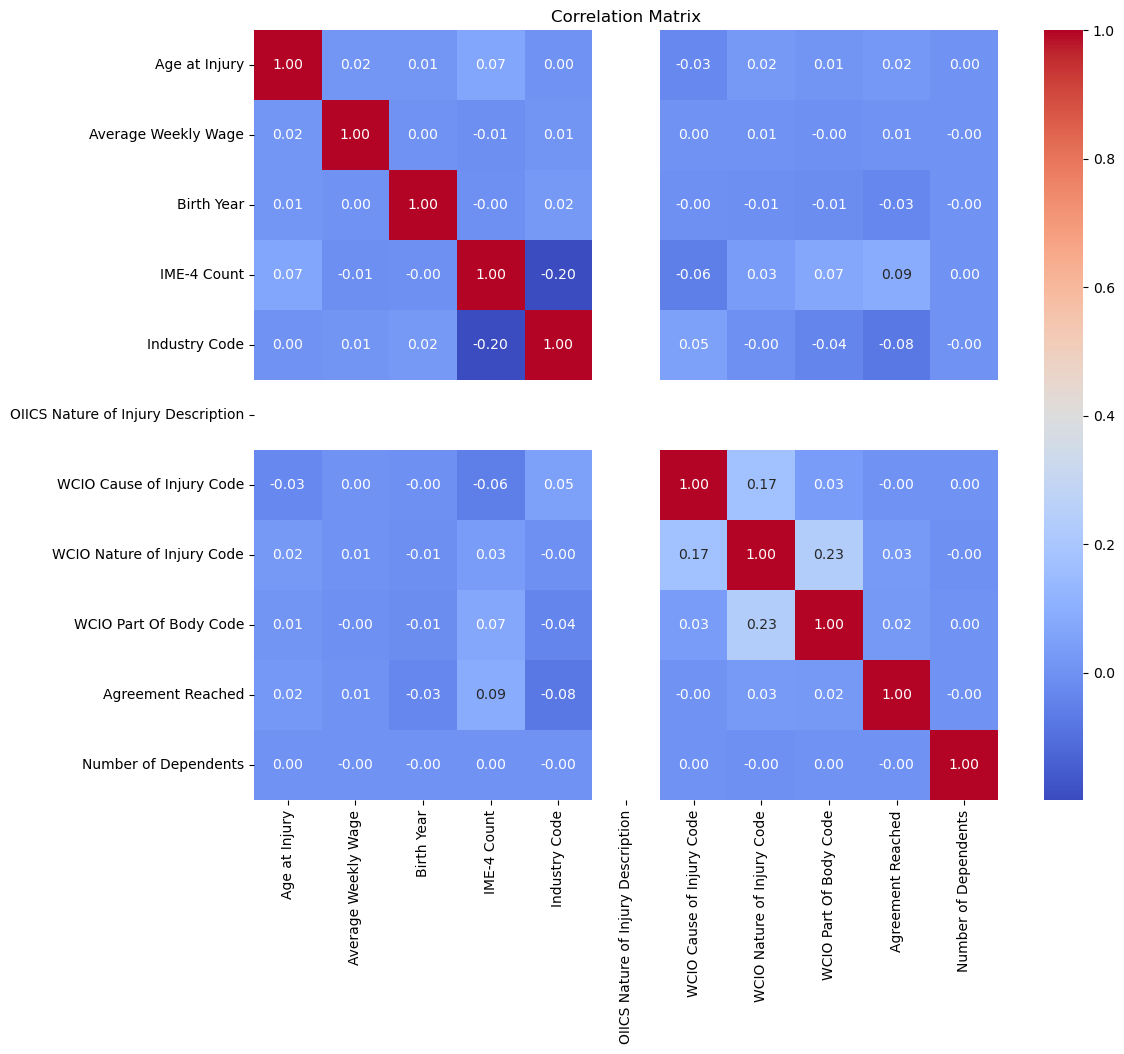

In [67]:
# Filter the dataframe to include only integer and float columns
numeric_train_data = train_data.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
correlation_matrix = numeric_train_data.corr()

# Plot the correlation matrix using matplotlib
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

### Outliers

In [ ]:
# Remove columns with all NaN values
numeric_train_data = numeric_train_data.dropna(axis=1, how='all')

# Plot each numerical feature in a separate plot
for column in numeric_train_data.columns:
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=numeric_train_data, x=column)
    plt.title(f'Boxplot of {column}')
    plt.xlabel('')
    plt.show()


Mainly outliers for _`Average Weekly Wage`_, _`Age at Injury`_ and _`WCIO Part of Body Code`_

### Data Preprocessing

- Drop the features with high null value percentage: _`OIICS Nature of Injury Description`_ for sure and _`IME-4 Count`_,           _`First Hearing Date`_ and _`C-3 Date`_
- Switch to binary columns: _`Attorney/Representative`_ and maybe _`COVID-19 Indicator`_
- Adjust columns to the correct data type if necessary
- No correlation for numerical values, so no reason to frop features here?
- Removal of outliers: _`Average Weekly Wage`_, _`Age at Injury`_ and _`WCIO Part of Body Code`_

In [48]:
# # Calculate the number of features
# num_features = df.shape[1]

# # Function to calculate the percentage of matching entries
# def matching_percentage(row1, row2):
#     matches = (row1 == row2).sum()
#     return matches / num_features

# # Find pairs of rows with over 80% matching entries
# matching_pairs = []
# threshold = 0.8

# for i in range(len(df)):
#     for j in range(i + 1, len(df)):
#         if matching_percentage(df.iloc[i], df.iloc[j]) >= threshold:
#             matching_pairs.append((i, j))

# matching_pairs

In [ ]:
# for i in df.select_dtypes(include='number').columns:
#     sns.histplot(data=df, x=i)
#     plt.show()